In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")

yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2019-01-01'
end = '2021-12-30'

# Tickers of assets
my_stocks = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'MSFT', 'PSA']
my_etfs= ['XIU.TO', 'SPY', 'AGG']
all_assets = my_stocks + my_etfs




# Downloading data for stock portfolio
data = yf.download(my_stocks, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = my_stocks
#Calculating returns
stock_returns = data[my_stocks].pct_change().dropna()
display(stock_returns.head())

[*********************100%***********************]  10 of 10 completed


,JCI,TGT,CMCSA,CPB,MO,APA,MMC,JPM,MSFT,PSA
Date,,,,,,,,,,
2019-01-03,0.2582%,0.7855%,1.2399%,-1.6065%,-1.4212%,-1.3032%,-0.5476%,-3.6788%,1.9174%,-1.3697%
2019-01-04,4.1943%,3.3776%,0.5511%,3.9987%,3.6865%,2.4484%,2.5693%,4.6509%,-1.1066%,1.3734%
2019-01-07,2.1539%,-1.0612%,2.5883%,1.6341%,0.0695%,0.4379%,-3.0219%,0.1275%,-0.2798%,4.8924%
2019-01-08,1.4864%,0.8185%,0.7498%,0.6936%,-0.1886%,0.6852%,0.5740%,0.7251%,1.7955%,-0.1005%
2019-01-09,5.1090%,0.9518%,1.7565%,0.0939%,-0.1690%,0.0866%,1.2230%,1.4300%,-0.6965%,0.9769%


In [2]:
# Calculate the Historical Return series of an equal-weighted portfolio of stocks
stock_port_weights = [0.1]*len(my_stocks)
weighted_returns = (stock_port_weights * stock_returns)
stock_port_ret = weighted_returns.sum(axis=1) # Historical Returns of the Stock Portion
stock_port_ret = pd.DataFrame(stock_port_ret)
stock_port_ret.columns = ['MY_STOCK_Portf']
display(stock_port_ret.head())

,MY_STOCK_Portf
Date,
2019-01-03,-0.5726%
2019-01-04,2.5744%
2019-01-07,0.7541%
2019-01-08,0.7239%
2019-01-09,1.0762%


In [3]:
# Collect the returns data for the ETFs
# Downloading data for stock portfolio
data = yf.download(my_etfs, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = my_etfs
#Calculating returns
etf_returns = data[my_etfs].pct_change().dropna()
etf_returns = pd.DataFrame(etf_returns)
display(etf_returns.head())

[*********************100%***********************]  3 of 3 completed


,XIU.TO,SPY,AGG
Date,,,
2019-01-03,0.4129%,-2.3863%,-1.0171%
2019-01-04,-0.2991%,3.3496%,1.5880%
2019-01-07,-0.1687%,0.7884%,0.4598%
2019-01-08,-0.0751%,0.9395%,0.7323%
2019-01-09,0.0846%,0.4674%,1.3630%


In [4]:
# Now, combine the historical returns of the ETFs with the Stock Portfolio Returns
all_returns = pd.merge(etf_returns, stock_port_ret, on='Date')
display(all_returns.head())

,XIU.TO,SPY,AGG,MY_STOCK_Portf
Date,,,,
2019-01-03,0.4129%,-2.3863%,-1.0171%,-0.5726%
2019-01-04,-0.2991%,3.3496%,1.5880%,2.5744%
2019-01-07,-0.1687%,0.7884%,0.4598%,0.7541%
2019-01-08,-0.0751%,0.9395%,0.7323%,0.7239%
2019-01-09,0.0846%,0.4674%,1.3630%,1.0762%


In [5]:
#!pip install pybind11

In [6]:
#!pip install riskfolio-lib

In [7]:
import riskfolio as rp


# Building the portfolio object
port = rp.Portfolio(returns=all_returns)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w)

,weights
XIU.TO,70.2238%
SPY,0.0000%
AGG,0.0000%
MY_STOCK_Portf,29.7762%


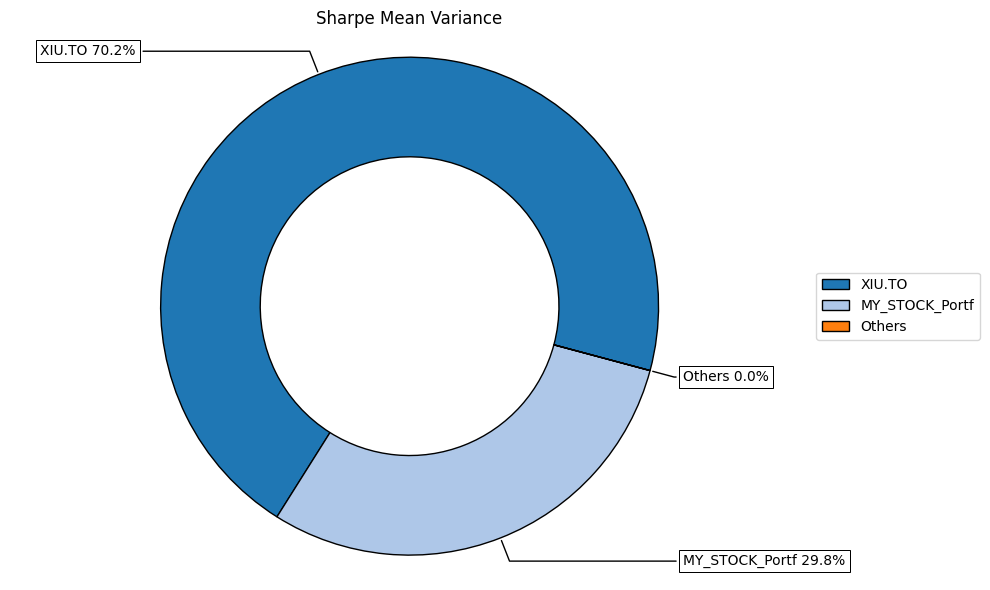

In [8]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

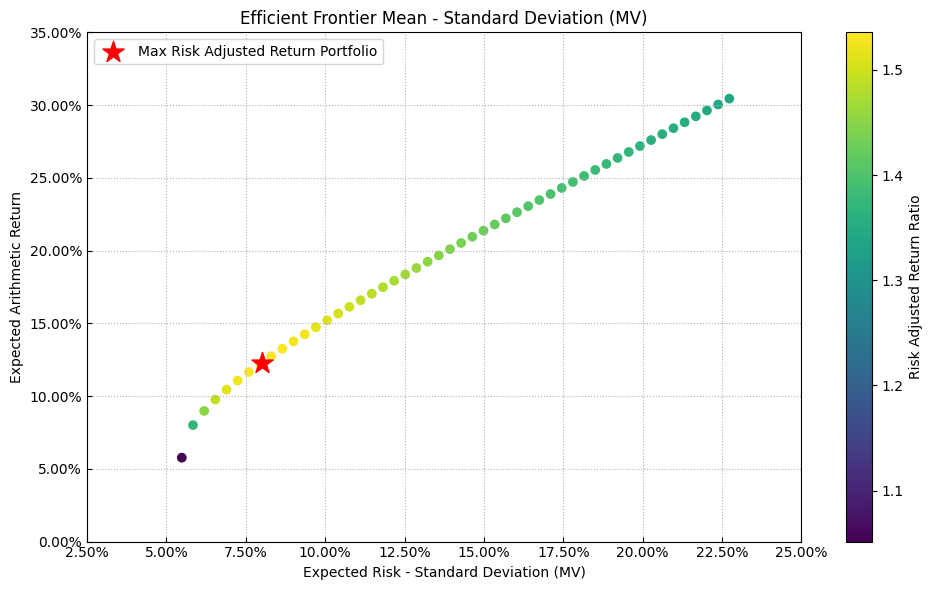

In [9]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [10]:

asset_classes = {'Assets': ['XIU.TO', 'SPY', 'AGG', 'MY_STOCK_Portf'], 
                 'Group': ['ETF', 'ETF','ETF', 'MY_STOCKS']}

asset_classes = pd.DataFrame(asset_classes)
#asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False],
               'Type': ['Classes', 'Classes', 'Classes', 'Classes'],
               'Set': ['Group', 'Group', 'Group', 'Group'],
               'Position': ['ETF', 'ETF', 'ETF', 'MY_STOCKS'],
               'Sign': ['>=', '>=', '>=', '>='],
               'Weight': [0.01, 0.01, 0.01, 0.5],
               'Type Relative': ['', '', '', ''],
               'Relative Set': ['', '', '', ''],
               'Relative': ['', '', '', ''],
               'Factor': ['', '', '', '']}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,Classes,Group,ETF,>=,1.0000%,,,,
1,False,Classes,Group,ETF,>=,1.0000%,,,,
2,False,Classes,Group,ETF,>=,1.0000%,,,,
3,False,Classes,Group,MY_STOCKS,>=,50.0000%,,,,


In [11]:
display(asset_classes)

,Assets,Group
0,XIU.TO,ETF
1,SPY,ETF
2,AGG,ETF
3,MY_STOCK_Portf,MY_STOCKS


In [12]:
A, B = rp.assets_constraints(constraints, asset_classes)

In [13]:
port.ainequality = A
port.binequality = B

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
rf = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.transpose())

,XIU.TO,SPY,AGG,MY_STOCK_Portf
weights,50.0000%,0.0000%,0.0000%,50.0000%


In [14]:
my_weights = w.T
my_weights.columns = ['XIU', 'SPY', 'AGG', 'MY_STOCKS']
display(my_weights)

,XIU,SPY,AGG,MY_STOCKS
weights,50.0000%,0.0000%,0.0000%,50.0000%


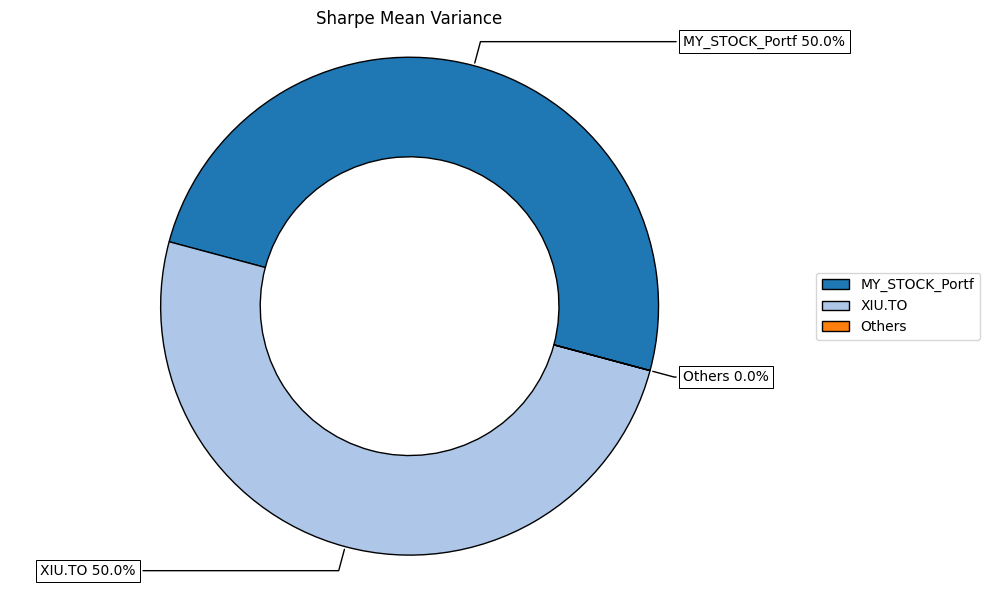

In [15]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.01, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)


#### We constructed a portfolio consisting of our 10-Stock Portfolio, and our ETFs in 2021-Dec with the weights given in 'w'

### What has been the return of this portfolio in 2022? 
#### Let's collect the price data in 2022 and calculate

In [16]:

# Date range
start = '2022-01-01'
end = '2022-12-31'

# Tickers of assets
my_stocks = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'MSFT', 'PSA']
my_etfs= ['XIU.TO', 'SPY', 'AGG']
all_assets = my_stocks + my_etfs

# Downloading data for stock portfolio
data = yf.download(all_assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = all_assets
#Calculating returns
asset_returns = data[all_assets].pct_change().dropna()
display(asset_returns.head())

[*********************100%***********************]  13 of 13 completed


,JCI,TGT,CMCSA,CPB,MO,APA,MMC,JPM,MSFT,PSA,XIU.TO,SPY,AGG
Date,,,,,,,,,,,,,
2022-01-05,-0.3089%,-3.5981%,0.0598%,1.2114%,-1.6306%,-1.8282%,-1.3880%,-0.7954%,-3.8388%,-0.8931%,-1.9202%,-2.2676%,-0.7683%
2022-01-06,-0.1063%,4.2958%,0.5775%,1.6938%,1.7082%,1.0624%,1.1284%,1.1719%,-0.7902%,0.9868%,-0.0939%,1.0880%,0.2168%
2022-01-07,-0.2925%,0.1688%,-0.9107%,1.8210%,-1.3809%,0.9908%,-1.7278%,1.1380%,0.0510%,-2.5811%,-0.3953%,-0.2464%,0.1545%
2022-01-10,-0.0889%,-0.8426%,0.9391%,-0.0218%,-1.0849%,0.0957%,0.8363%,1.5471%,0.0732%,1.0986%,-0.1244%,-1.4559%,0.0309%
2022-01-11,0.1868%,8.7695%,1.2272%,-1.6798%,1.4666%,0.1016%,0.3330%,-2.0973%,0.2259%,0.8421%,0.9108%,0.0572%,0.9254%


In [17]:
port_weights =[0.1*my_weights.MY_STOCKS]*len(my_stocks) + [my_weights.XIU] + [my_weights.SPY] + [my_weights.AGG]
port_weights= np.transpose(port_weights)

weighted_asset_returns = port_weights * asset_returns

display(weighted_asset_returns.shape)
port_ret_2022 = weighted_asset_returns.sum(axis=1) # Returns of the Stock Portfolio in 2022
port_ret = pd.DataFrame(port_ret_2022)
port_ret.columns = ['MY_Portfolio_Rets']
display(port_ret.head())

(254, 13)

,MY_Portfolio_Rets
Date,
2022-01-05,-1.6106%
2022-01-06,0.5394%
2022-01-07,-0.3338%
2022-01-10,0.0654%
2022-01-11,0.9242%


In [18]:

# Cumulative Portfolio Return
C_port_ret = (1 + port_ret).cumprod()

print("Last Portfolio Value:")
display(C_port_ret[(len(C_port_ret)-1):])   


Last Portfolio Value:


,MY_Portfolio_Rets
Date,
2022-12-30,89.0993%


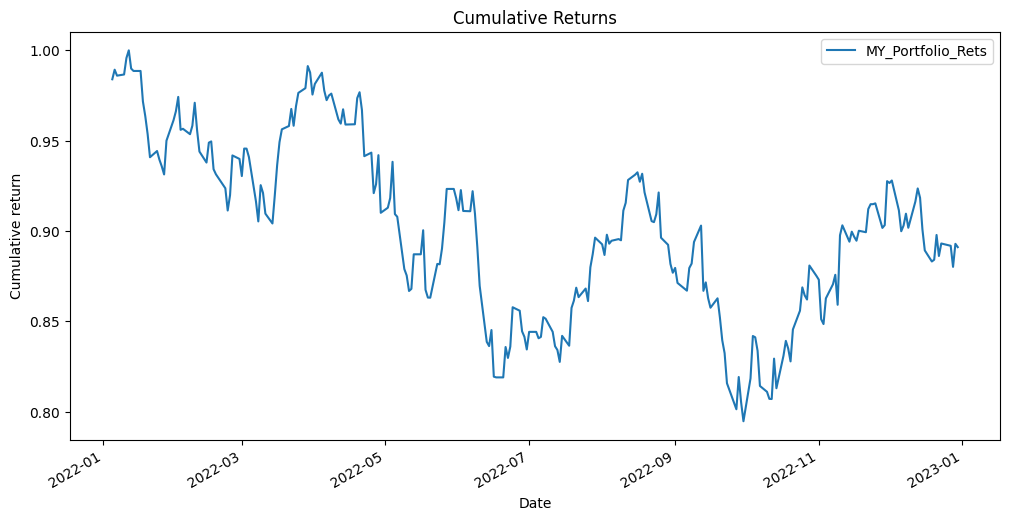

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 1, 1)
C_port_ret.plot(ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative return')
ax1.set_title('Cumulative Returns')
plt.show()

#### If we had simulated the possible outcomes of returns in 2021-Dec based on historical data, how would that look like?
#### 

In [20]:
# We can use the historical returns 'all_returns' to get the parameters of the simulations
## Calculate the covariance matrix:
returns = all_returns

T = 10/12
N_SIMS = 10 ** 5

cov_mat = returns.cov()
mu = np.mean(returns, axis=0).values*252
sigma = np.std(returns, axis=0).values*np.sqrt(252)

display(sigma)
display(mu)

array([0.05581324, 0.21931541, 0.20473134, 0.22714595])

array([0.04597689, 0.2572482 , 0.18152058, 0.30445138])

In [21]:

## Perform the Cholesky decomposition of the covariance matrix:

def GBMsimulator(seed, So, mu, sigma, Cov, T, N):
    """
    Parameters
    seed:   seed of simulation
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    """

    np.random.seed(seed)
    dim = np.size(So)
    t = np.linspace(0., T, int(N))
    A = np.linalg.cholesky(Cov)
    S = np.zeros([dim, int(N)])
    S[:, 0] = So
    for i in range(1, int(N)):    
        drift = (mu - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, t

In [22]:
seed = 22                       

dim = len(w); T = 10/12; N_SIMS = 1000

S0 = np.array([1, 1, 1, 1])
N_steps = int(T*252)

assets, time = GBMsimulator(seed, S0, mu, sigma, cov_mat, T, N_steps)


# Number of Simulations

np.random.seed(seed)
                                      

Simulated_Paths = np.zeros([N_SIMS, dim, N_steps])

Simulated_Paths[0, :, :] = assets

for k in range(1, N_SIMS):
    seed = int(np.random.uniform(1,2**32-1,1))
    Simulated_Paths[k, :, :] = GBMsimulator(seed, S0, mu, sigma, cov_mat, T, N_steps)[0]

# Plot one of the simulations, e.g. the 0th

#plt.figure(figsize = (16,8))
#plt.title('Multidimensional Correlated GBM', fontsize = 18)
#plt.xlabel('Time', fontsize = 18)

#for j in range(dim):
#    plt.plot(time, SS[0, j, 210])
#plt.show()


display(Simulated_Paths.shape)

(1000, 4, 210)

In [23]:
Simul_Last_Values = Simulated_Paths[:,:,(N_steps-1)]
#display(Simul_Last_Values.shape)
Simul_Last_Portf_Values = w.transpose().values*Simul_Last_Values
#display(Simul_Last_Portf_Values.shape)
X = pd.DataFrame(Simul_Last_Portf_Values).sum(axis=1)
display(X)

0     115.9697%
1     113.7901%
2     114.0437%
3     117.0624%
4     115.4029%
         ...   
995   114.5020%
996   114.9357%
997   114.8996%
998   114.2584%
999   114.6242%
Length: 1000, dtype: float64

Portfolio Value Histogram:


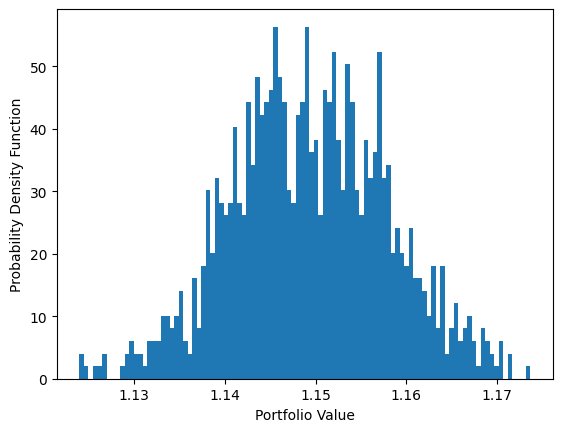

In [24]:
import matplotlib.pyplot as pl

print('Portfolio Value Histogram:')
pl.figure()
pl.hist(X,bins=100, density=True, stacked=True)
pl.xlabel('Portfolio Value')
pl.ylabel('Probability Density Function')
pl.show()
